# Object-based filtering of pixel classifications <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Background

Geographic Object-Based Image Analysis (GEOBIA), aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description

In this notebook, we take the pixel-based classifications generated in the `4_Predict.ipynb` notebook, and filter the classifications by image-objects. To do this, we first need to conduct image segmentation using the function `rsgislib.segmentation.runShepherdSegmentation`. This image sgementation algorithm is fast and scalable.  The image segmentation is conducted on the `NDVI` layer output in the previous notebook.
To filter the pixel observations, we assign to each segment the majority (mode) pixel classification using the `scipy.ndimage.measurements import _stats` module. 

1. Convert the NDVI layer to a .kea file format (a requirement for RSGSISLIB)
2. Run the image segmentation
3. Calculate the **mode** statistic for each segment
4. Write the new object-based classification to disk as COG
5. An advanced section that demonstrates running a tiled, parallel image segmentation (useful if segmenting a very large geotiff)

***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import os
import sys
import gdal
import shutil
import xarray as xr
import numpy as np
import geopandas as gpd
import subprocess as sp
from datacube.utils.cog import write_cog
from rsgislib.segmentation import segutils
from scipy.ndimage.measurements import _stats

sys.path.append('../Scripts')
from deafrica_classificationtools import HiddenPrints


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Analysis Parameters

In [2]:
pred_tif = 'results/classifications/prediction.tif'
tif_to_seg = 'results/classifications/NDVI.tif'
min_seg_size = 100 #in number of pixels

results = 'results/classifications/'


## Generate an object-based classification

### Convert to .kea format

In [3]:
#inputs to image seg
kea_file = tif_to_seg[:-4]+'.kea'
segmented_kea_file = tif_to_seg[:-4]+'_segmented.kea'

#convert tiff to kea
gdal.Translate(destName=kea_file,
               srcDS=tif_to_seg,
               format='KEA',
               outputSRS='EPSG:6933')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f1d0feac9c0> >

### Run image segmentation

In [4]:
%%time
#store temp files somewhere
tmp='tmp/'
if not os.path.exists(tmp):
    os.mkdir(tmp)

#run image seg
with HiddenPrints():
    segutils.runShepherdSegmentation(inputImg=kea_file,
                                     outputClumps=segmented_kea_file,
                                     tmpath=tmp,
                                     numClusters=20,
                                     minPxls=min_seg_size)
    

CPU times: user 53.1 s, sys: 280 ms, total: 53.4 s
Wall time: 53.8 s


### Open segments and pixel-based predictions

In [5]:
segments=xr.open_rasterio(segmented_kea_file).squeeze().values
pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')

### Calculate mode

In [6]:
count, _sum =_stats(pred, labels=segments, index=segments)
mode = _sum > (count/2)
mode = xr.DataArray(mode,  coords=pred.coords, dims=pred.dims, attrs=pred.attrs).astype(np.int16)

### Clean up intermediate files

In [7]:
shutil.rmtree(tmp)
os.remove(kea_file)
os.remove(segmented_kea_file)

### Write result to disk

In [8]:
write_cog(mode, results+ 'prediction_object_.tif', overwrite=True)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


PosixPath('results/classifications/prediction_object_.tif')

### Plot result

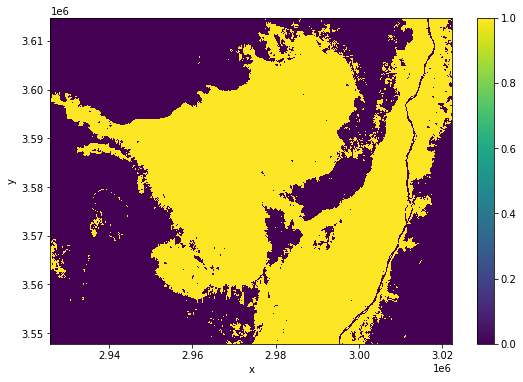

In [9]:
mode.plot(size=6);

***
## Optional: Tiled, parallel image segmentation

Image segmentation at large scales can be both time and memory intensive. The module `deafrica_segmentation.performTiledSegmentation` builds upon the image segmentation algorithm developed by Shepherd et al. (2019) (implemented in the package RSGISlib) to run image segmentation across multiple cpus. A full description of their approach can be found in _Clewey et al. (2014) A Python-Based Open Source System for Geographic Object-Based Image Analysis (GEOBIA) Utilizing Raster Attribute Tables_. The code below demonstrates how to use the `deafrica_segmentation.performTiledSegmentation` module to conduct a tiled, parallel image semgmentation. 

The tiling approach is based on the bounding coordinates of the geotiff. If a geotiff is irregularly shaped such that a tile(s) contains none of the input geotiff, then the segmentation will fail. If this occurs, check the `<>S1Tiles.shp` file output during stage 1 of the algorithm. Overlay this file on top of your input geotiff to check if there are empty tiles. At the moment, the only solution is to change the extent of the geotiff to be more regularly shaped. The `validDataTileFraction` variable will handle tiles that contain a small fraction of the input geotiff, tiles containing less than the specified fraction are merged with a neighboring tile. The image below shows an example of the tiling approach with merged tiles:

<img align="center" src="data/figs/tilingApproach.PNG" width="35%">

Below, we will conduct the same analysis as we did in the first example above, but this time the image segmentation will be conducted using the `deafrica_segmentation.performTiledSegmentation()` function. For the default example, this will be slower than the serial version, however, when conducting image segmentation over very large geotiffs, this option will be preferred.

In [10]:
sys.path.append('../Scripts')
from deafrica_segmentation import performTiledSegmentation

## Analysis Parameters

* `validDataTileFraction`: what fraction of a tile should contain valid data? Below this threshold a tile will be merged with its neighbour. e.g. `0.3`
* `tile_width, tile_height`: The tile size parameters in number of pixels

In [11]:
#new parameters to add
validDataTileFraction=0.2 
tile_width, tile_height = 1500, 1500

#previous paramters we added above, reposting here
pred_tif = 'results/classifications/prediction.tif'
tif_to_seg = 'results/classifications/NDVI.tif'
min_seg_size = 100
results = 'results/classifications/'


### Automatically find the number of cpus

In [12]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(round(float(sp.getoutput('env | grep CPU')[-3:]),0))

print('ncpus = '+str(ncpus))

ncpus = 2


## Tiled, parallel image segmentation

### Convert .tif to .kea

In [13]:
#store temp files somewhere
tmp='tmp/'
if not os.path.exists(tmp):
    os.mkdir(tmp)

#inputs to image seg
kea_file = tif_to_seg[:-4]+'.kea'
segmented_kea_file = tif_to_seg[:-4]+'_segmented.kea'

#convert tiff to kea
gdal.Translate(destName=kea_file,
               srcDS=tif_to_seg,
               format='KEA',
               outputSRS='EPSG:6933')


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f1cb8840d50> >

### Run the segmentation

In [14]:
#run the segmentation
with HiddenPrints():
    performTiledSegmentation(kea_file,
                        segmented_kea_file,
                        tmpDIR=tmp,
                        numClusters=20,
                        validDataThreshold=validDataTileFraction, 
                        tileWidth=tile_width,
                        tileHeight=tile_height,
                        minPxls=min_seg_size,
                        ncpus=ncpus)

#remove tmp folder
shutil.rmtree(tmp)


### Open segments and pixel-based predictions

In [15]:
segments=xr.open_rasterio(segmented_kea_file).squeeze().values
pred = xr.open_rasterio(pred_tif).squeeze().drop_vars('band')

### Calculate mode

In [16]:
count, _sum =_stats(pred, labels=segments, index=segments)
mode = _sum > (count/2)
mode = xr.DataArray(mode,  coords=pred.coords, dims=pred.dims, attrs=pred.attrs).astype(np.int16)

### Clean up intermediate files

In [17]:
shutil.rmtree(tmp)
os.remove(kea_file)
os.remove(segmented_kea_file)

### Plot the result

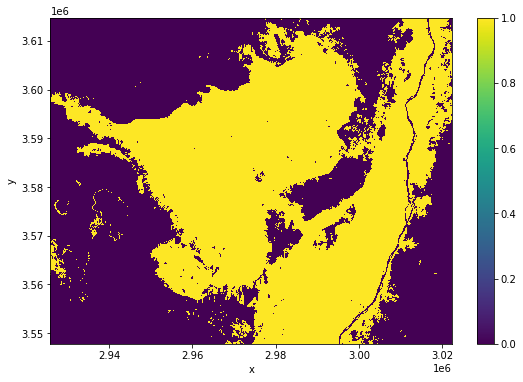

In [18]:
mode.plot(size=6);

## Recommended next steps

This is the last notebook in the `Scalable Machine Learning on the ODC` workflow! To revist any of the other notebooks, use the links below.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. [Evaluate_optimize_fit_classifier](3_Evaluate_optimize_fit_classifier.ipynb)
4. [Predict](4_Predict.ipynb)
5. **Object-based_filtering (this notebook)**


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2021
